# 野々村「(号泣)この前処r、前処理を・・・変えたい！！｣
先行研究では10秒間隔の波形を4秒スライドで切り出し、その信号にケプストラム平均正規化を行うことで精度の向上を図っていました。
これはDNNというモデルを活用するうえで１次元信号の形を変えたくなかったというのもあると思います。

しかし、CNNならば話は別です。CNNは画像の特徴を捉えることができるという点から、1次元信号を2次元画像に適切に変換することで、より良いモデルが作成できるのではと考えました。  
具体的には、1次元信号に短時間フーリエ変換を施すことでメル周波数スペクトグラムに変換し、その画像を入力として学習させます。  
スペクトグラムは縦軸に周波数、横軸に時間をとり、色の濃淡で周波数の大きさを表す空間です。

## 波形の読み込み

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utills.datapath as dpath

# 被験者データ
tester = dpath.LMH.M001.value.ka_center
start = 180
end = 480

# pandasでcsvを読み込み
wave = pd.read_csv(".."/tester.value/"wave.csv", names=["L", "R", "L_gain", "R_gain"])
posture = pd.read_csv(".."/tester.value/"position.csv")

lraw = wave['L'].to_numpy()
rraw = wave['R'].to_numpy()
lgain = wave['L_gain'].to_numpy()
rgain = wave['R_gain'].to_numpy()
posture = posture.to_numpy()

left = lraw * 2.818 ** lgain
right = rraw * 2.818 ** rgain

# left = left[128*start: 128*end]
# right = right[128*start:128*end]

# 波形を見る

iter :  0


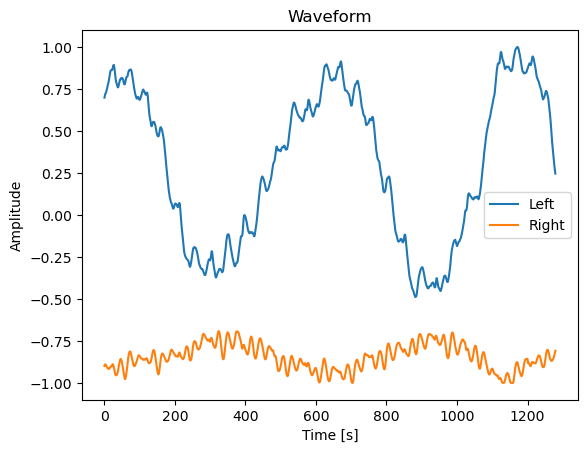

In [58]:
import matplotlib.pyplot as plt
import utills.preprocess as pp
from gmrf.x64.Release import gmrf
from cutill.x64.Release import cutill as c

start = 300
end = start + 10

left_part = left[128*start:128*end]
right_part = right[128*start:128*end]

left_part, right_part = c.normalize(left_part, right_part)
lg = gmrf.dvgmrf.dvgmrf()
rg = gmrf.dvgmrf.dvgmrf()

lg._lambda = 1e-11
lg._lambda_rate = 1e-13
lg._alpha = 1e-15
lg._alpha_rate = 1e-18
lg._epoch = 1000
lg.set_eps(1e-12)

rg = lg

left_denoised = lg.denoise([left_part])
right_denoised = rg.denoise([right_part])
print("iter : ", lg._epoch)

pp.wave_plot(left_part, right_part)
# pp.wave_plot(left_part, left_denoised)
# pp.wave_plot(right_part, right_denoised)

## メルスペクトログラムによる解析
STFTは短時間フーリエ変換 (short-time fourier transform : STFT) と呼ばれる解析手法。  
元の信号を短い窓で区切り、窓関数と通して解析した周波数を縦軸、横軸を時間にとった周波数スペクトグラムを見る。  
この時得られたスペクトルをメル尺度に変換したものをメルスペクトグラムといい、低周波では敏感に、高周波では鈍感になるように見える。

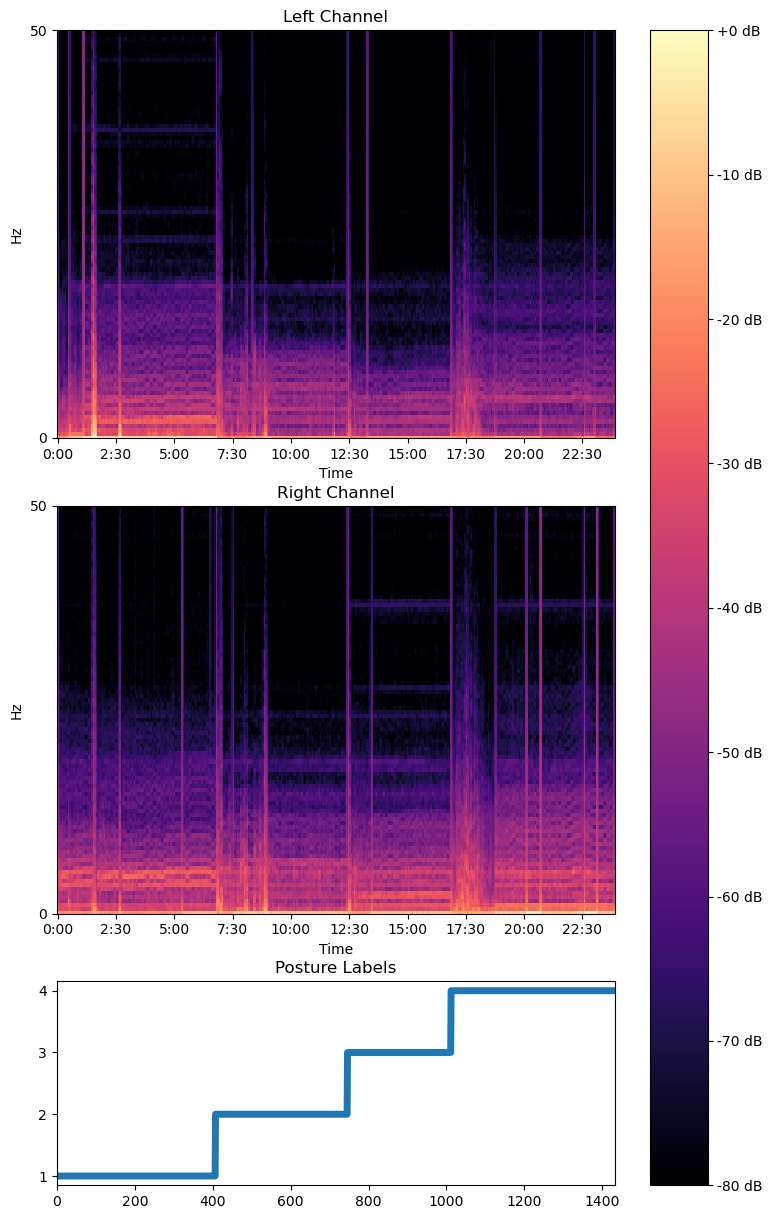

In [59]:
import librosa
import librosa.display
from matplotlib.ticker import MaxNLocator

# ハイパパラメータ
sr = 128    # サンプリング周波数

# スペクトログラムに変換(left)
left_S = librosa.feature.melspectrogram(y=left, sr=sr, n_fft=sr*20, win_length=sr*10, hop_length=sr*4)
left_S = librosa.power_to_db(abs(left_S), ref=np.max)

# スペクトログラムに変換(right)
right_S = librosa.feature.melspectrogram(y=right, sr=sr, n_fft=sr*20, win_length=sr*10, hop_length=sr*4)
right_S = librosa.power_to_db(abs(right_S), ref=np.max)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 15), 
                                     gridspec_kw={'height_ratios': [3, 3, 1.5]})

# 左チャンネルのスペクトログラム
img1 = librosa.display.specshow(left_S, x_axis="time", y_axis="mel", sr=sr, ax=ax1)
ax1.set_title("Left Channel")
ax1.set_ylim(0, 50)

# 右チャンネルのスペクトログラム
img2 = librosa.display.specshow(right_S, x_axis="time", y_axis="mel", sr=sr, ax=ax2)
ax2.set_title("Right Channel")
ax2.set_ylim(0, 50)

# 姿勢ラベルの表示
ax3.plot(np.arange(0, len(posture)), posture, lw=5)
ax3.set_title("Posture Labels")
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlim(0, len(posture))

# 共通のカラーバーを追加
fig.colorbar(img2, ax=[ax1, ax2, ax3], format='%+2.0f dB')

# レイアウトを調整して表示
fig.savefig("../images/mel_spectgrum.png", bbox_inches="tight")
plt.show()

## スペクトログラムによる解析
周波数分解能を高めるために、1280点で切り出した波形をゼロパディングして2560点でfftします。

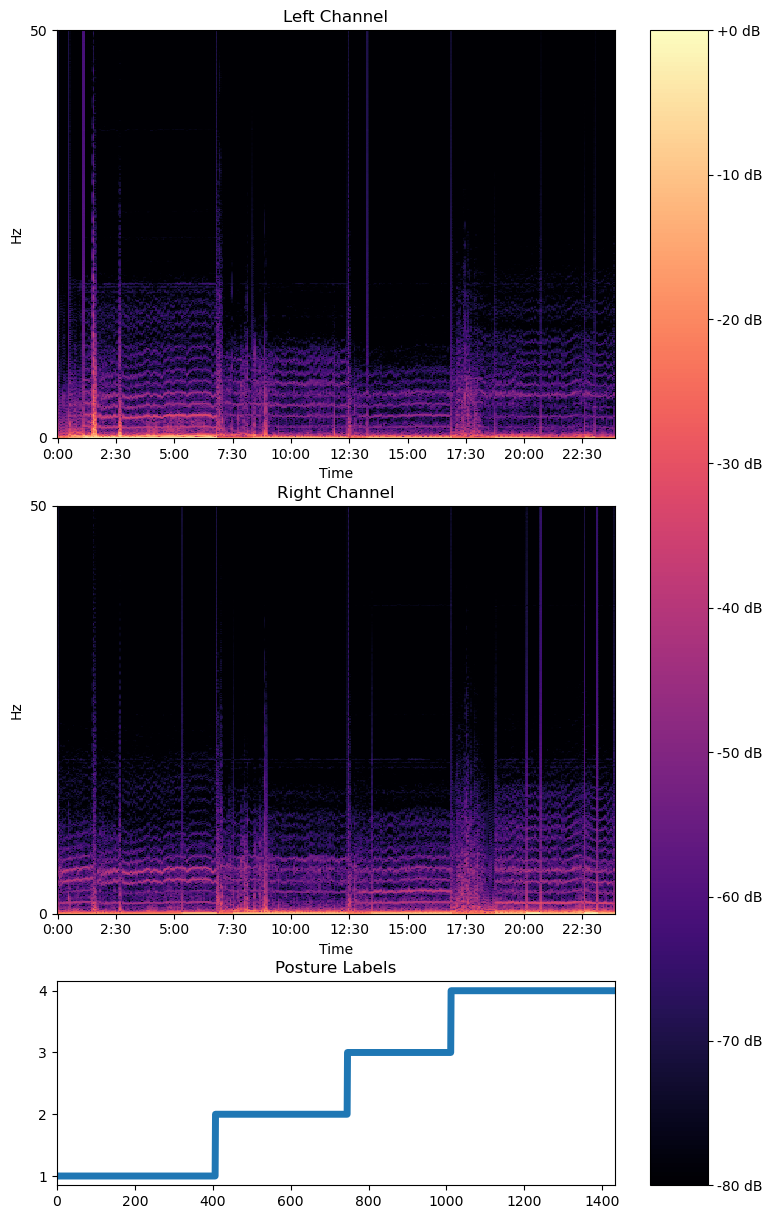

In [60]:
import librosa
import librosa.display
from matplotlib.ticker import MaxNLocator

# ハイパパラメータ
sr = 128    # サンプリング周波数

# スペクトログラムに変換(left)
left_S = librosa.stft(y=left, n_fft=sr*20, win_length=sr*10, hop_length=sr*4)
left_S = librosa.amplitude_to_db(abs(left_S), ref=np.max)
left_f0 = librosa.yin(y=left, fmin=0.5, fmax=32)
    

# スペクトログラムに変換(right)
right_S = librosa.stft(y=right, n_fft=sr*20, win_length=sr*10, hop_length=sr*4)
right_S = librosa.amplitude_to_db(abs(right_S), ref=np.max)
right_f0 = librosa.yin(y=right, fmin=0.5, fmax=32)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 15), 
                                     gridspec_kw={'height_ratios': [3, 3, 1.5]})

# 左チャンネルのスペクトログラム
img1 = librosa.display.specshow(left_S, x_axis="time", y_axis="log", sr=sr, ax=ax1)
# ax1.plot(left_f0, label='f0')
ax1.set_title("Left Channel")
ax1.set_ylim(0, 50)

# 右チャンネルのスペクトログラム
img2 = librosa.display.specshow(right_S, x_axis="time", y_axis="log", sr=sr, ax=ax2)
ax2.set_title("Right Channel")
ax2.set_ylim(0, 50)

# 姿勢ラベルの表示
ax3.plot(np.arange(0, len(posture)), posture, lw=5)
ax3.set_title("Posture Labels")
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlim(0, len(posture))

# 共通のカラーバーを追加
fig.colorbar(img2, ax=[ax1, ax2, ax3], format='%+2.0f dB')

# レイアウトを調整して表示
fig.savefig("../images/spectgrum.png", bbox_inches="tight")
plt.show()

## constant-Q変換による解析

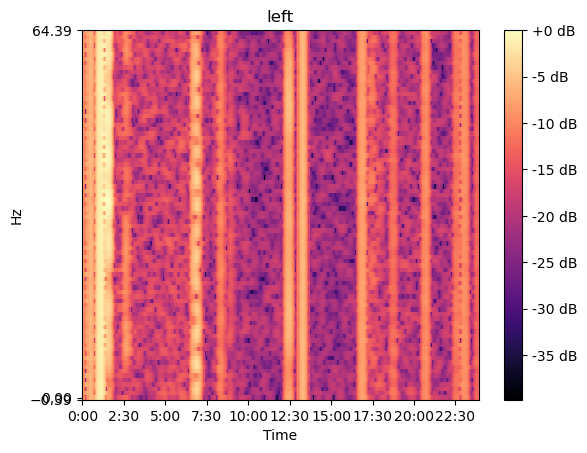

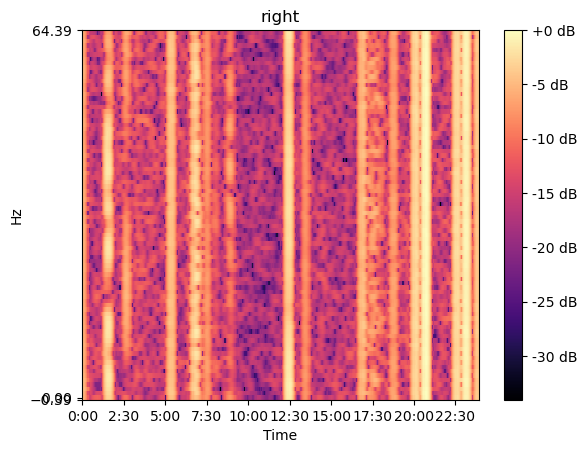

In [61]:
import librosa
import librosa.display

# ハイパパラメータ
sr = 128    # サンプリング周波数

# スペクトグラムに変換(left)
S = librosa.cqt(y=left, sr=sr, hop_length=512, bins_per_octave=1280)
S = abs(S)
S = librosa.power_to_db(S, ref=np.max)

img = librosa.display.specshow(S, x_axis="time", y_axis="mel", sr=sr)
plt.colorbar(img, format='%+2.0f dB')
plt.title("left")
plt.show()

# スペクトグラムに変換(right)
S = librosa.cqt(y=right, sr=sr, hop_length=512, bins_per_octave=1280)
S = abs(S)
S = librosa.power_to_db(S, ref=np.max)

img = librosa.display.specshow(S, x_axis="time", y_axis="mel", sr=sr)
plt.colorbar(img, format='%+2.0f dB')
plt.title("right")
plt.show()

# ケプストラム領域の比較
周波数とメル周波数からケプストラムに変換した結果を確認したい。

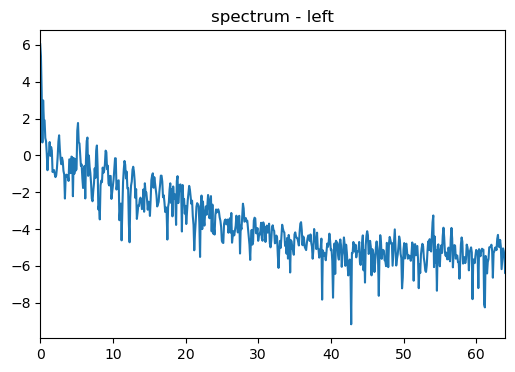

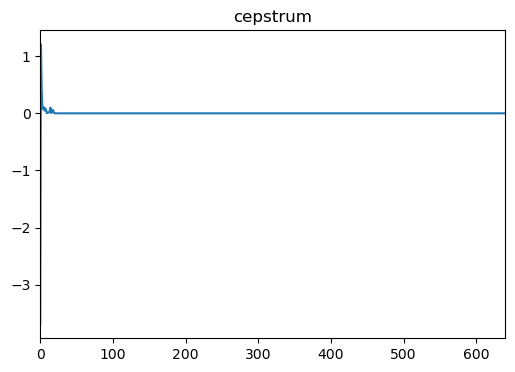

c:\ProgramData\Anaconda3\envs\satou\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\ProgramData\Anaconda3\envs\satou\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


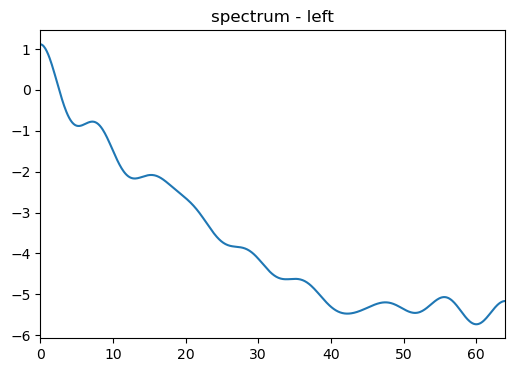

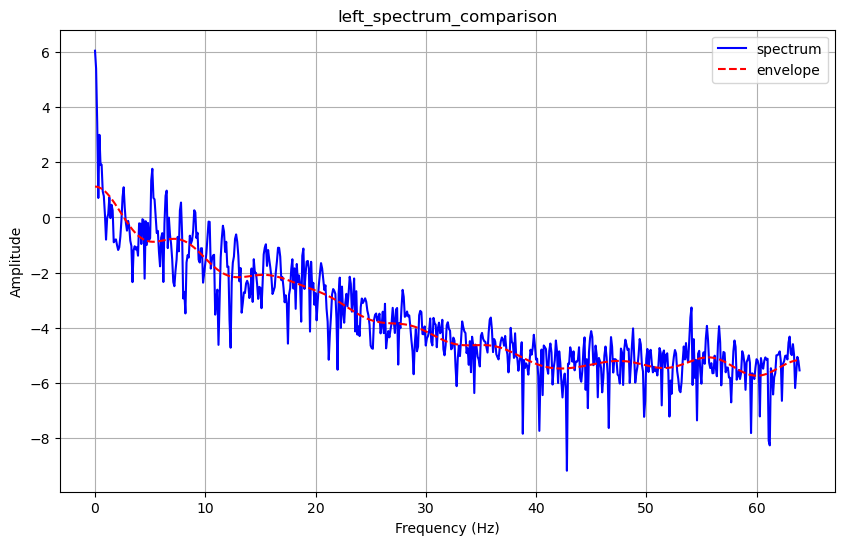

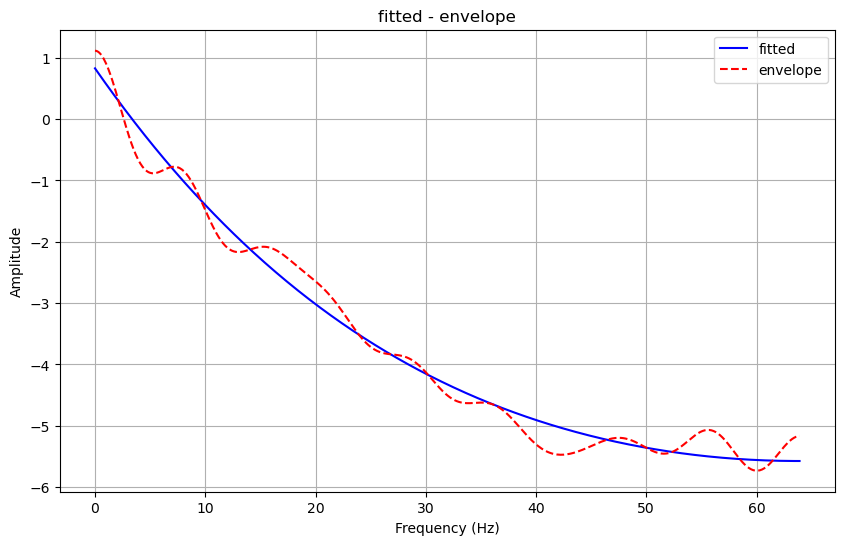

In [62]:
start = 120
end = start + 1

wave_l, wave_r = left[1280*start:1280*end], right[1280*start:1280*end]
wave_l, wave_r = c.normalize(wave_l, wave_r)
han = np.hanning(len(wave_l))     # ハン窓
wave_l *= han
wave_r *= han
spectrum_l, spectrum_r = np.abs(np.fft.fft(wave_l)), np.abs(np.fft.fft(wave_r))
spectrum_l, spectrum_r = np.log(spectrum_l), np.log(spectrum_r)

spectrum_l_fitted = spectrum_l - pp.fit(spectrum_l)
spectrum_r_fitted = spectrum_r - pp.fit(spectrum_r)

# spectrum_l[0:10] *= 1e-10
# spectrum_r[0:10] *= 1e-10

# ケプストラムに変換
cepstrum_l = np.fft.ifft(spectrum_l)
cepstrum_r = np.fft.ifft(spectrum_r)

cutoff = 20
bandPathLifter = 'low'
if bandPathLifter == 'high':
    cepstrum_l[:cutoff] *= 1e-10
    cepstrum_l[len(cepstrum_l)-cutoff-1:] *= 1e-10
elif bandPathLifter == 'low':
    cepstrum_l[cutoff:len(cepstrum_l)-cutoff+1] *= 1e-10

cep_to_spectrum_l = np.fft.fft(cepstrum_l)
# cep_to_spectrum_l[0:10] *= 1e-10

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 128, 0.1), spectrum_l)
plt.title("spectrum - left")
plt.xlim(0, len(spectrum_l)//20)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 1280), cepstrum_l.real)
plt.xlim(0, 640)
plt.title("cepstrum")
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 128, 0.1), cep_to_spectrum_l)
plt.title("spectrum - left")
plt.xlim(0, len(cep_to_spectrum_l)//20)
plt.show()

pp.freq_plot(spectrum_l, cep_to_spectrum_l, 128, title='left_spectrum_comparison', legend=['spectrum', 'envelope'])
pp.freq_plot(pp.fit(spectrum_l), cep_to_spectrum_l, 128, title='fitted - envelope', legend=['fitted', 'envelope'])

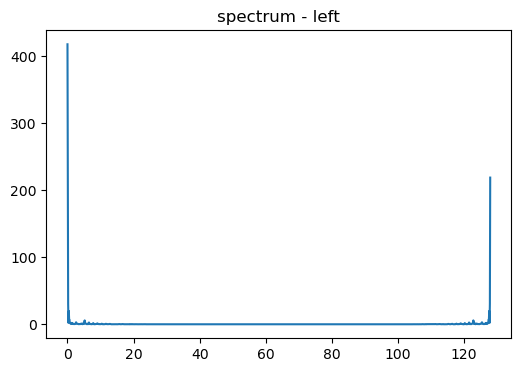

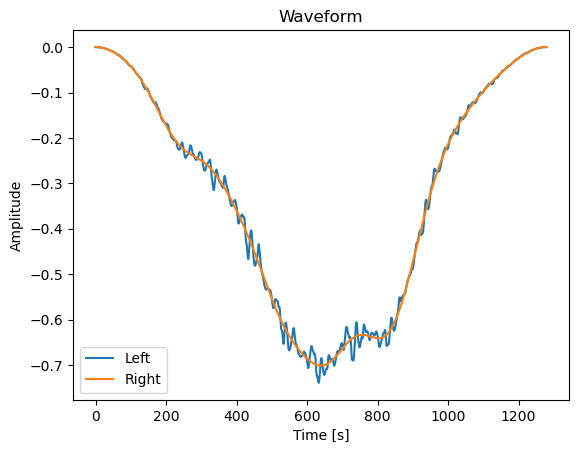

In [63]:
# han = np.hanning(len(wave_l))     # ハン窓
# wave_l *= han
spectrum_l, spectrum_r = np.fft.fft(wave_l), np.fft.fft(wave_r)

spectrum_l_abs = abs(spectrum_l)
spectrum_r_abs = abs(spectrum_r)

cutoff =10
bandPathFilter = "low"
if bandPathFilter == 'low':
    spectrum_l[cutoff: len(spectrum_l)-cutoff] *= 1e-10
    spectrum_r[cutoff: len(spectrum_l)-cutoff] *= 1e-10
elif bandPathFilter == 'high':
    spectrum_l[0:cutoff] *= 1e-10
    spectrum_l[len(spectrum_l)-cutoff:len(spectrum_l)-1] *= 1e-10

plt.figure(figsize=(6, 4))
plt.plot(np.arange(0, 128, 0.1), spectrum_l_abs)
plt.title("spectrum - left")
plt.show()

l = np.fft.ifft(spectrum_l).real
r = np.fft.ifft(spectrum_r).real

pp.wave_plot(wave_l, l)